# Neural Activity Model

### Relevant Packages and Utility Functions

In [1]:
using ImageFiltering, PyPlot;


function report_progress(i::Int,iterations::Int,tstart::Float64)
    """ Prints to screen the model progress. 

    Parameters
    ----------
    i: Int 
        Current iteration of the model.

    iterations: Int 
        Number of iterations set to run. 

    tstart: Float64 
        Time of starting the model. 
    """
    
    progress = (i*100)/iterations
    t = time()
    tpassed = (t-tstart)/60
    time2go = ((tpassed/progress)*100) - tpassed

    print("$(@sprintf("%.3f",progress))% completed.  Time passed: $(@sprintf("%.3f",tpassed)) mins.    Expected time left: $(@sprintf("%.3f",time2go))  \r")
    flush(STDOUT)

end


function gen_pairs(ni,nj)
    """ Generates all possible pairs of adjacent retinal neurons. 

    Parameters
    ----------
    ni: Int
        Number of retinal cells along nasal-temporal axis.
    nj: Int
        Number of retinal cells along dorsal-ventral axis.

    Returns
    -------
    num_pairs: Int
        Total number of possible pairs of adjacent neurons
        in the presynaptic sheet.

    pairs: 2D Array
        Takes format pairs[pair_num,:] = [i1,j1,i2,j2] where i1,i2 and j1,j2 are
        retinal coordinates in the nasal-temporal and dorsal-ventral axes
        respectively. 
    """
    
    num_pairs = 2*(ni-1)*(nj-1) + (ni-1) + (nj-1)
    pairs = zeros(Int,(num_pairs,4))
    count = 1 
    for i=1:ni, j=1:nj
        if i!=ni
            pairs[count,:] = [i,j,i+1,j]
            count += 1
        end

        if j!=nj
            pairs[count,:] = [i,j,i,j+1]
            count += 1
        end
    end

    return (num_pairs,pairs)

end


function get_tec_pms(nk,nl)
    """ Obtains coordinates of middle 4 tectal cells. 

    Parameters
    ----------
    nk: Int
        Number of tectal cells along posterior-anterior axis.

    nl: Int
        Number of tectal cells along lateral-medial axis. 
    
    Returns
    -------
    pms: Array{Array{Int64,1},1}
        k,l coordinates of the middle 4 tectal neurons. 
    """ 
    
    kmid1 = fld(nk,2) 
    kmid2 = kmid1+1

    lmid1 = fld(nl,2) 
    lmid2 = lmid1 + 1
    
    pms = [[kmid1,lmid1],[kmid1,lmid2],[kmid2,lmid1],[kmid2,lmid2]]

    return pms
    
end

get_tec_pms (generic function with 1 method)

## Model Parameters

In [2]:
const FRAME_RATE = 500
const dt = 1

const INIT_SYN_MEAN = 2.5                                 # S
const INIT_SYN_SD = 0.14

const POLARITY_MULT = 5
const ACTIVITY_THRESH = 10                                # theta
const MEM_TIME_CONST = 0.5                                # alpha
const STATIONARITY_CONST = 0.005
const SYN_MOD_THRESH = 2                                  # epsilon
const HEBB_CONST = 0.0016                                 # h
const INPUT_CLUSTER_SIZE = 2                              # c

const beta = 0.05
const gamma = 0.025
const delta = -0.06
const DIST_FILTER = centered([0 0 0 delta 0 0 0;
            0 0 delta gamma delta 0 0;
        0 delta gamma beta gamma delta 0;
            delta gamma beta 0 beta gamma delta;
            0 delta gamma beta gamma delta 0;
                0 0 delta gamma delta 0 0;
                    0 0 0 delta 0 0 0]);
const offsets = [-3,-2,-1,0,1,2,3];


## Initialisation

### Initialise Synaptic Weights

In [3]:
function init_syns(ni,nj,nk,nl,tec_pms)
    """ Initialises synaptic weights according to a normal distribution.
    Polarity markers are added to the middle 4 cells of each sheet.

    Parameters
    ----------
    ni: Int
        Number of retinal neurons along nasal-temporal axis. 

    nj: Int
        Number of retinal neurons along dorsal-ventral axis.

    nk: Int
        Number of tectal cells along posterior-anterior axis.

    nl: Int
        Number of tectal cells along lateral-medial axis.

    tec_pms: Array{Array{Int64,1},1}
        k,l coordinates of tectal polarity markers. 

    Returns
    --------
    syn_weights: Array{Float64,4}
        Synaptic weights of connections between each retinal and tectal neuron.
    """
    
    syn_weights = randn(ni,nj,nk,nl)*INIT_SYN_SD + INIT_SYN_MEAN

    imid1 =  fld(ni,2)
    imid2 = imid1 + 1

    jmid1 = fld(nj,2)
    jmid2 = jmid1 + 1

    tmid1 = tec_pms[1]
    k1 = tmid1[1]
    l1 = tmid1[2]

    tmid2 = tec_pms[2]
    k2 = tmid2[1]
    l2 =tmid2[2]

    tmid3 = tec_pms[3]
    k3 = tmid3[1]
    l3 = tmid3[2]

    tmid4 = tec_pms[4]
    k4 = tmid4[1]
    l4 = tmid4[2]

    syn_weights[imid1,jmid1,k1,l1] *= POLARITY_MULT
    syn_weights[imid1,jmid2,k2,l2] *= POLARITY_MULT
    syn_weights[imid2,jmid1,k3,l3] *= POLARITY_MULT
    syn_weights[imid2,jmid2,k4,l4] *= POLARITY_MULT

    syn_weights = norm_syns(syn_weights,ni,nj,nk,nl)

    return syn_weights

end

init_syns (generic function with 1 method)

### Constructing model object

In [4]:
type ActivityModel
    ret_dim1::Int
    ret_dim2::Int
    tec_dim1::Int
    tec_dim2::Int
    tec_pms::Array{Array{Int64,1},1}
    pairs::Array{Int,2}
    num_pairs::Int
    syn_weights::Array{Float64,4}
    rf_centres::Array{Float64,3}
    iter_weights::Array{Float64,5}
    iter_rfs::Array{Float64,4}
    cur_pot::Array{Float64,2}
    activity::Array{Float64,2}
    conv::Array{Float64,2}
    pot_change::Array{Float64,2}
    iinds::Array{Int,1}
    jinds::Array{Int,1}

    ## Constructor
    function ActivityModel(ni,nj,nk,nl,tec_pms)
        s = init_syns(ni, nj, nk, nl,tec_pms)
        (num_pairs,pairs) = gen_pairs(ni,nj)
        rf = zeros(nk, nl,2)
        iw = zeros(1,ni,nj,nk,nl)
        irf = zeros(1,nk,nl,2)
        cur_pot = zeros(nk,nl)
        activity = zeros(nk,nl)
        conv = zeros(nk,nl)
        pot_change = zeros(nk,nl)
        iinds = repeat([ i for i in 1:ni],inner=nj)
        jinds = repeat([ j for j in 1:nj],outer=ni)

        new(ni, nj, nk, nl, tec_pms,pairs,num_pairs, s, rf,iw,irf,
            cur_pot,activity,conv,pot_change,iinds,jinds)
    end

end

## Model Procedure

### 1. Activate adjacent retinal cells

In [5]:
function activate_ret(pairs,num_pairs)
    """ Chooses a random pair of adjacent retinal neurons to activate.
    
    Parameters
    ----------
    pairs: Array{Int,2}
        i,j coordinates of all adjacent pairs of retinal neurons. 
        Takes the form pairs[pair_num,:] = [i1,j1,i2,j2].
    num_pairs: int 
        Number of distinct adjacent pairs of retinal neurons.
        
    Returns
    -------
    pair: Array{Int,1}
        i,j coordinates of the chosen pair of retinal neurons. 
    """
    
    pair = Array{Int}(1)
    pair  = pairs[rand(1:num_pairs),:]
    return pair
end

activate_ret (generic function with 1 method)

### 2. Depolarise tectal cells

In [6]:
function activate_tec(model::ActivityModel,pair)
    """ Computes linear sum of activated retinal neurons and their
    synaptic weights. 

    Parameters
    ----------
    model: ActivityModel
        ActivityModel object containing current values of each model 
        component.

    pair: Array{Int,1} 
        i,j, coordinates of activated retinal neurons. 
    """
    
    i1 = pair[1]
    j1 = pair[2]
    i2 = pair[3]
    j2 = pair[4]

    model.cur_pot = model.syn_weights[i1,j1,:,:] + model.syn_weights[i2,j2,:,:]
end

activate_tec (generic function with 1 method)

### 3. Threshold tectal depolarisation

In [7]:
function thresh(cur_pot)
    """ Applies threshold to tectal membrane potentials. 

    Parameters
    ----------
    cur_pot: Array{Float64,2}
        Membrane potential in each tectal neuron. 

    Returns
    -------
    cur_pot: Array{Float64,2}
        Post-threshold activity of each tectal neuron. 
    """
    
    cur_pot[find(x -> x < ACTIVITY_THRESH, cur_pot)] = 0
    cur_pot[find(x -> x > ACTIVITY_THRESH, cur_pot)] -= ACTIVITY_THRESH
    return cur_pot
end

thresh (generic function with 1 method)

### 4. Apply tectal excitation/inhibition

In [8]:
function tec_feedback(model::ActivityModel)
    """ Computes excitation and inhibition effects from neighbouring tectal
    neurons. 

    Parameters
    ----------
    model: ActivityModel
        ActivityModel object containing current values of each model 
        component.  

    Returns
    -------
    feedback: Array{Float64,2} 
        Convolution of tectal activity with a Manhatten distance filter. 
        Represents contributions of neighbouring tectal neurons to 
        membrane potential. 
    """
    
    nk = model.tec_dim1
    nl = model.tec_dim2
    feedback = zeros(Float64,nk,nl)
    
    for k in 1:nk, l in 1:nl, koff in offsets, loff in offsets
        kind = k+koff
        lind = l+loff
        if kind>0 && lind >0 && kind <= nk && lind <= nl
            feedback[k,l] += model.activity[kind,lind]*DIST_FILTER[koff,loff]
        end        
    end

    return feedback
end

tec_feedback (generic function with 1 method)

### 5. Update membrane potentials

In [9]:
function update_potential(model::ActivityModel)
    """ Simulates differential equations, using Euler's method, to update
    tectal membrane potentials (see Willshaw, von der Malsburg, 1976). 

    Parameters
    ----------
    model: ActivityModel
        ActivityModel object containing current values of each model 
        component.
    """
    
    init_pot = Array{Float64}(2)
    init_pot = copy(model.cur_pot)
    mean_change = 1
    new_mean = mean(model.cur_pot)
    old_mean = 0
    while mean_change > (STATIONARITY_CONST*old_mean)
        old_mean = new_mean
        model.activity = thresh(copy(model.cur_pot))
        model.conv = tec_feedback(model)
        model.pot_change = (init_pot + model.conv) - (MEM_TIME_CONST*model.cur_pot) 
        model.cur_pot += model.pot_change*dt
        new_mean = mean(model.cur_pot)
        mean_change = abs(new_mean-old_mean)
    end

    model.activity = thresh(model.cur_pot)

end

update_potential (generic function with 1 method)

### 6. Apply Hebbian learning rule

In [10]:
function update_syns(model::ActivityModel,pair)
    """ Applies Hebbian learning rule to connections between activated 
    retinal neurons and strongly excitated tectal neurons. 

    Parameters
    ----------
    model: ActivityModel
        ActivityModel object containing current values of each model 
        component.

    pair: Array{Int,1} 
        i,j, coordinates of activated retinal neurons.  
    """
    
    i1 = pair[1]
    j1 = pair[2]
    i2 = pair[3]
    j2 = pair[4]

    linds = find(x -> x > SYN_MOD_THRESH,model.activity)

    if length(linds)!=0
        for lind in linds
            (k,l) = ind2sub(model.activity,lind)
            model.syn_weights[i1,j1,k,l] += HEBB_CONST*model.activity[k,l]
            model.syn_weights[i2,j2,k,l] += HEBB_CONST*model.activity[k,l]
        end
    end

    model.syn_weights = norm_syns(model.syn_weights,model.ret_dim1,
        model.ret_dim2,model.tec_dim1,model.tec_dim2)

end

update_syns (generic function with 1 method)

### 7. Normalise synaptic weights

In [11]:
function norm_syns(syn_weights,ni,nj,nk,nl)
    """ Normalises the synaptic weights so that the mean weight 
    contacting each tectal neuron remains constant. 

    Parameters
    ----------
    syn_weights: Array{Float64,4} 
        Synaptic weights of each connection between retinal and tectal neurons.

    ni: Int
        Number of retinal neurons along nasal-temporal axis. 

    nj: Int
        Number of retinal neurons along dorsal-ventral axis.

    nk: Int
        Number of tectal cells along posterior-anterior axis.

    nl: Int
        Number of tectal cells along lateral-medial axis.
    
    Returns
    -------
    syn_weights: Array{Float64,4}
        Normalised synaptic weights. 
    """
    
    reshaped_weights = reshape(syn_weights,(ni*nj,nk*nl))
    mu = mean(reshaped_weights,1)
    norm_weights = (reshaped_weights*INIT_SYN_MEAN)./mu
    syn_weights = reshape(norm_weights,(ni,nj,nk,nl))
    return syn_weights
end

norm_syns (generic function with 1 method)

### Putting it all together...

In [12]:
function iteration(model::ActivityModel)
    """ Simulates one cycle of the model simulation. 

    A simulation cycle consists of:
    1) Exciting a pair of retinal neurons at random.
    2) Computing the subseqent activation in the tectum.
    3) Simulating tectal interactions.
    4) Updating synaptic weights. 

    Parameters
    ----------
    model: ActivityModel
        ActivityModel object containing current values of each model 
        component.
    """
    
    pair = activate_ret(model.pairs,model.num_pairs)
    activate_tec(model,pair)
    update_potential(model)
    update_syns(model,pair)
end

iteration (generic function with 1 method)

## Determining tectal receptive fields

In [13]:
function calc_rf_centres(model::ActivityModel)
    """ Computes retinal coordinates for the receptive field centre of each
    tectal neuron. For each tectal neuron, the coordinates of the receptive
    field centre is calculated as a sum over all retinal positions 
    weighted by the corresponding synatpic weights. The weighted
    sum is then normalised by dividing over the sum of synaptic weights 
    arriving at the tectal neuron being considered.  

    Parameters
    ----------
    model: ActivityModel 
        ActivityModel object containing current values of each model 
        component.
    """
    
    ni = model.ret_dim1
    nj = model.ret_dim2
    nk = model.tec_dim1
    nl = model.tec_dim2

    rshpe_syns = reshape(model.syn_weights,(ni*nj,nk*nl))
    rfdenom = sum(rshpe_syns,1)

    rfnume = sum((rshpe_syns.*model.iinds),1)
    irf = reshape(rfnume./rfdenom,(nk,nl))

    rfnume = sum((rshpe_syns.*model.jinds),1)
    jrf = reshape(rfnume./rfdenom,(nk,nl))

    model.rf_centres[:,:,1] = irf
    model.rf_centres[:,:,2] = jrf

end

calc_rf_centres (generic function with 1 method)

## Running Model Simulation

In [14]:
function run(model::ActivityModel,iterations::Int)
    """ Runs simulation of Activity Model.

    Parameters
    ----------
    model: ActivityModel
        ActivityModel object containing current values of each model 
        component.
        
    iterations: Int
        Number of iterations to iterate simulation cycle. 
    """
    
    ni = model.ret_dim1
    nj = model.ret_dim2
    nk = model.tec_dim1
    nl = model.tec_dim2

    model.iter_weights = zeros(floor(Int64,iterations/FRAME_RATE)+1,
        ni,nj,nk,nl)
    model.iter_rfs = zeros(floor(Int64,iterations/FRAME_RATE)+1,
        nk,nl,2)

    tstart = time()

    for i in 1:iterations
        iteration(model)

        if i % FRAME_RATE == 0
            index = floor(Int64,i/FRAME_RATE)
            model.iter_weights[index,:,:,:,:] = model.syn_weights
            calc_rf_centres(model)
            model.iter_rfs[index,:,:,:] = model.rf_centres
            report_progress(i,iterations,tstart)
        end
    end
end

run (generic function with 1 method)

## Visualising Retinotopic Map

In [15]:
function plot_iteration(model::ActivityModel,iteration::Int,title::String)
    """ Plots a lattice plot representing the receptive fields of 
    each tectal neuron at a given iteration of the model simulation. 

    Parameters
    ----------
    model: ActivityModel
        ActivityModel object containing current values of each model 
        component. 

    iteration: int 
        Iteration of model simulation to display receptive fields. 
    
    title: String
        Text to display as subplot title. 
    """
    
    rec_fields = model.iter_rfs[iteration,:,:,:]
    ax = PyPlot.gca()
    ax[:set_xlim](1,model.ret_dim1)
    ax[:set_ylim](1,model.ret_dim2)
    ax[:set_aspect]("equal")
    PyPlot.grid("on")
    
    for k in 1:model.tec_dim1
        PyPlot.plot(rec_fields[k,:,1],rec_fields[k,:,2],c="k")
    end


    for l in 1:model.tec_dim2
        PyPlot.plot(rec_fields[:,l,1],rec_fields[:,l,2],c="k")
    end
    
    PyPlot.title(title)
    PyPlot.xlabel("Nasal-Temporal Position")
    PyPlot.ylabel("Dorsal-Ventral Position")
  
end



function plot_map(model::ActivityModel)
    """ Sets up lattice plot figure and displays the receptive field 
    centres at 4 equally spaced iterations of the model simulation. 

    Parameters
    ----------
    model: ActivityModel
        ActivityModel object containing current values of each model 
        component. 
    """
    fig = figure()
    iterations = (length(model.iter_rfs[:,1,1,1])-1)
    PyPlot.subplot(2,2,1)
    plot_iteration(model,1,"Iteration: 1")
    
    PyPlot.subplot(2,2,2)
    it = fld(iterations,3)
    plot_iteration(model,it,"Iteration: $(it*FRAME_RATE)")
    
    PyPlot.subplot(2,2,3)
    it = fld(2*iterations,3)
    plot_iteration(model,it,"Iteration: $(it*FRAME_RATE)")
    
    PyPlot.subplot(2,2,4)
    it = iterations-1
    plot_iteration(model,it,"Iteration: $(it*FRAME_RATE)")
    
    PyPlot.tight_layout()

end

plot_map (generic function with 1 method)

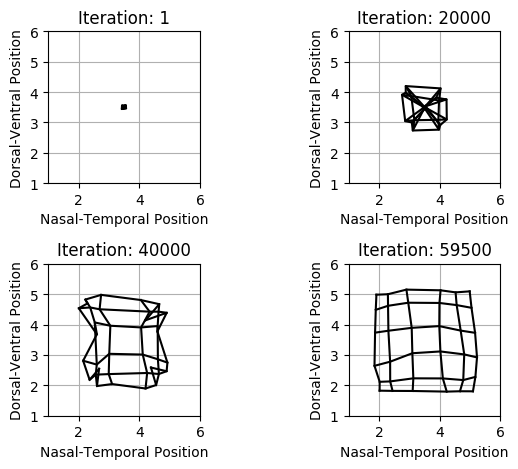

In [16]:
am1 = ActivityModel(6,6,6,6,get_tec_pms(6,6));
run(am1,60000);
plot_map(am1)

## Systems Matching

### 6x6 | 9x6

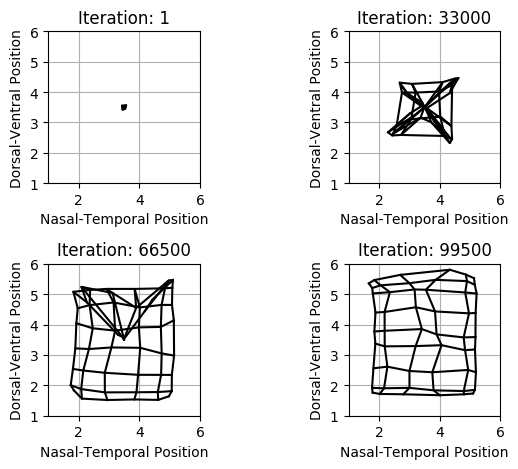

In [17]:
am2 = ActivityModel(6,6,9,6,get_tec_pms(9,6));
run(am2,100000);
plot_map(am2)

### 8x8 | 6x6

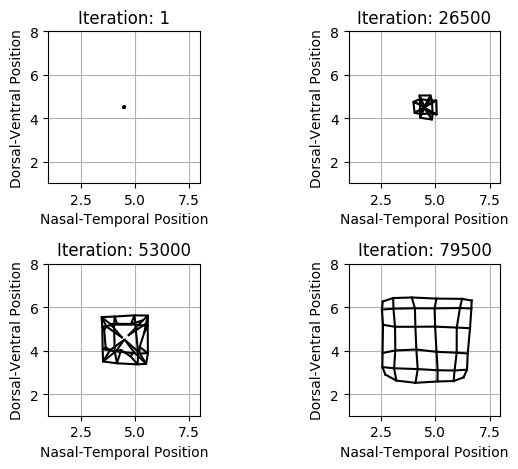

In [18]:
am3 = ActivityModel(8,8,6,6,get_tec_pms(6,6));
run(am3,80000);
plot_map(am3)

### 8x8 | 9x6

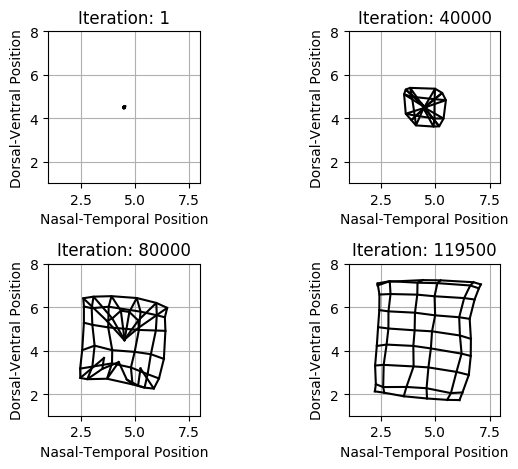

In [23]:
am4 = ActivityModel(8,8,9,6,get_tec_pms(9,6));
run(am4,120000);
plot_map(am4)

## Changing Polarity

In [20]:
function change_polarity(perm,nk,nl)
    tec_pms = get_tec_pms(nk,nl)
    cop = copy(tec_pms)
    display()
    for n in 1:4
        tec_pms[n] = cop[perm[n]] 
    end
    
    return tec_pms
    
end

change_polarity (generic function with 1 method)

### Rotation

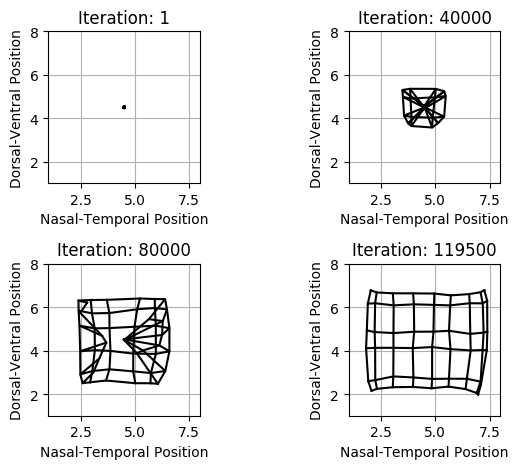

In [21]:
tec_pms1 = change_polarity([2,4,1,3],9,6)
am5 = ActivityModel(8,8,9,6,tec_pms1);
run(am5,120000);
plot_map(am5)

### Twist

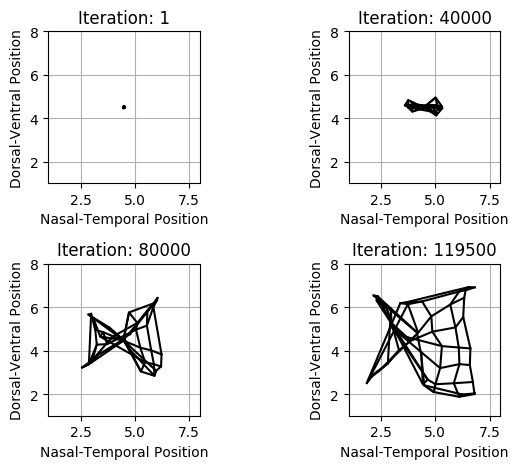

In [22]:
tec_pms2 = change_polarity([1,4,3,2],9,6)
am6 = ActivityModel(8,8,9,6,tec_pms2);
run(am6,120000);
plot_map(am6)